# Portfolio Optimization Methods (Walk-Forward Backtesting)

Goal: compare portfolio allocation methods under realistic constraints, with transaction costs
and walk-forward backtesting (rolling train/test).


## 1. Setup


In [ ]:
from pathlib import Path
FIG_DIR = Path("../reports/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)


In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 5)


## 2. Data
We download daily adjusted close prices from Yahoo Finance using `yfinance`.


In [5]:
TICKERS = ["AAPL", "MSFT", "GOOGL", "AMZN", "META"]
START_DATE = "2018-01-01"
END_DATE = "2024-12-31"

TICKERS, START_DATE, END_DATE


(['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META'], '2018-01-01', '2024-12-31')

In [6]:
prices = yf.download(
    TICKERS,
    start=START_DATE,
    end=END_DATE,
    auto_adjust=True,
    progress=False
)["Close"]

prices = prices.dropna()
prices.head()


Ticker,AAPL,AMZN,GOOGL,META,MSFT
Date,,,,,
2018-01-02,40.341888,59.450500,53.258099,180.161514,79.050377
2018-01-03,40.334866,60.209999,54.166733,183.388977,79.418282
2018-01-04,40.522221,60.479500,54.377140,183.051331,80.117264
2018-01-05,40.983582,61.457001,55.098194,185.553864,81.110580
2018-01-08,40.831356,62.343498,55.292725,186.973923,81.193336


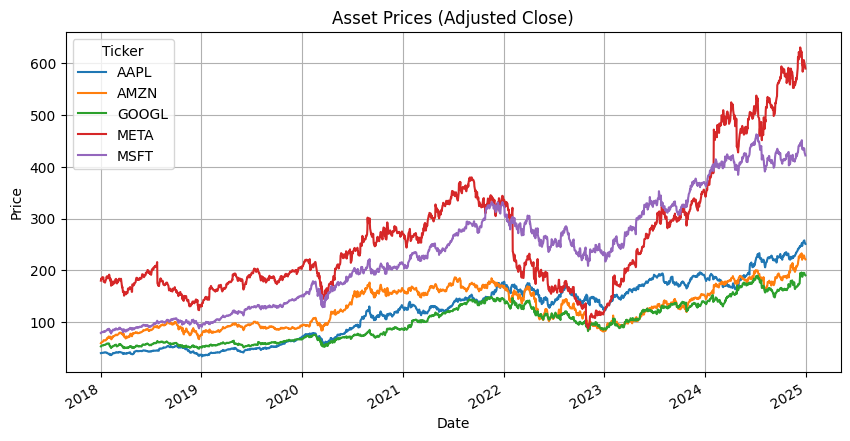

WindowsPath('../reports/figures/prices.png')

In [7]:
ax = prices.plot()
ax.set_title("Asset Prices (Adjusted Close)")
ax.set_ylabel("Price")
ax.grid(True)

plt.savefig(FIG_DIR / "prices.png", dpi=200, bbox_inches="tight")
plt.show()

FIG_DIR / "prices.png"


In [8]:
returns = prices.pct_change().dropna()
returns.head()


Ticker,AAPL,AMZN,GOOGL,META,MSFT
Date,,,,,
2018-01-03,-0.000174,0.012775,0.017061,0.017914,0.004654
2018-01-04,0.004645,0.004476,0.003884,-0.001841,0.008801
2018-01-05,0.011385,0.016163,0.013260,0.013671,0.012398
2018-01-08,-0.003714,0.014425,0.003531,0.007653,0.001020
2018-01-09,-0.000115,0.004676,-0.001274,-0.002178,-0.000680


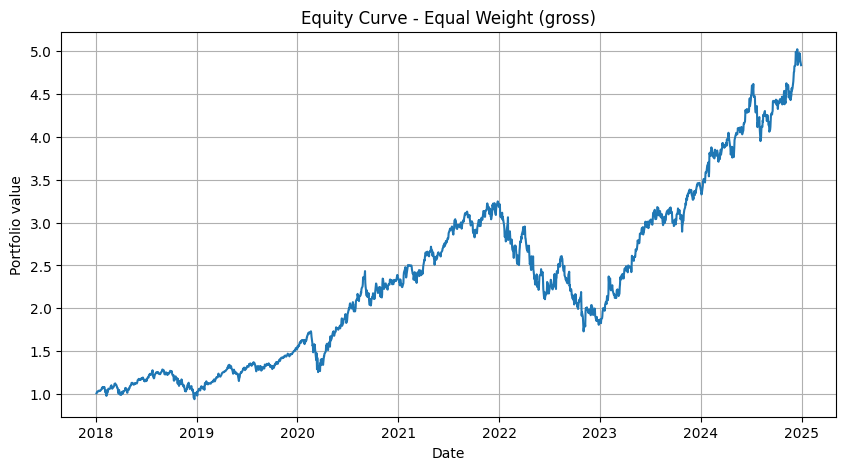

WindowsPath('../reports/figures/equity_curve.png')

In [9]:
w_eq = np.repeat(1/len(TICKERS), len(TICKERS))  # equal weights
port_ret_eq = returns @ w_eq

equity_eq = (1 + port_ret_eq).cumprod()

plt.plot(equity_eq)
plt.title("Equity Curve - Equal Weight (gross)")
plt.ylabel("Portfolio value")
plt.xlabel("Date")
plt.grid(True)

plt.savefig(FIG_DIR / "equity_curve.png", dpi=200, bbox_inches="tight")
plt.show()

FIG_DIR / "equity_curve.png"


### Performance Metrics (Baseline)

To evaluate portfolio performance, we compute the following metrics:

- **CAGR (Compound Annual Growth Rate)**: measures the annualized growth rate of the portfolio.
- **Volatility**: annualized standard deviation of portfolio returns, used as a risk proxy.
- **Sharpe Ratio**: risk-adjusted return, defined as the ratio of average excess return to volatility.
- **Maximum Drawdown**: worst peak-to-trough loss, capturing downside risk.

These metrics provide a first quantitative assessment of the baseline Equal-Weight portfolio,
before introducing optimization, constraints, and walk-forward rebalancing.
The Equal-Weight portfolio is used as a naive baseline, providing a simple benchmark against which
more sophisticated optimization methods will be compared.


In [10]:
def compute_metrics(portfolio_returns, equity_curve, freq=252):
    cagr = equity_curve.iloc[-1] ** (freq / len(equity_curve)) - 1
    vol = portfolio_returns.std() * np.sqrt(freq)
    sharpe = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(freq)

    running_max = equity_curve.cummax()
    drawdown = equity_curve / running_max - 1
    max_dd = drawdown.min()

    return pd.Series({
        "CAGR": cagr,
        "Volatility": vol,
        "Sharpe": sharpe,
        "Max Drawdown": max_dd
    })


metrics_eq = compute_metrics(port_ret_eq, equity_eq)
metrics_eq


CAGR            0.253270
Volatility      0.281062
Sharpe          0.944375
Max Drawdown   -0.466735
dtype: float64

At this stage, performance is evaluated using a static Equal-Weight allocation.
In the following section, we introduce portfolio optimization methods to improve
risk-adjusted returns under realistic constraints.
